In [72]:
from datacube import Datacube
import numpy as np
import xarray as xr
import rasterio
import matplotlib.pyplot as plt


import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import display_map

In [73]:
dc = Datacube(app='DEA_Land_Cover')

In [74]:
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords = [xr.IndexVariable(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units))
              for x in geobox.dims]
    return xr.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox=None, name=None, nodata=None):
    """Blit like"""
    with rasterio.open(file) as src:
            band = rasterio.band(src, 1)  # do not attempt to read entire extent into memory
            array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
            rasterio.warp.reproject(source=band,
                                    destination=array,
                                    dst_crs=geobox.crs.crs_str,
                                    dst_transform=geobox.affine,
                                    dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

In [75]:
tile = 'x39y13'
# tile = 'x40y12'
# tile = 'x39y12'
x_value, y_value = tile.split('y')
x_value = int(x_value[1:3])
y_value = int(y_value)
minx = -2688000 + (96000 * x_value)
maxx = minx + 96000
miny = -5472000 + (96000 * y_value)
maxy = miny + 96000
tile_coords = {'x' : (minx, maxx), 'y': (miny, maxy)}


from pyproj import Proj, transform

inProj = Proj(init='EPSG:3577')
outProj = Proj(init='EPSG:4283')
new_x, new_y = transform(inProj,outProj,tile_coords['x'],tile_coords['y'])
print(new_x, new_y)

(143.98009498051834, 144.95196143190137) (-38.18138928759789, -37.23088162134588)


/env/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/env/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_292/1395391105.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  new_x, new_y = transform(inProj,outProj,tile_coords['x'],tile_c

In [76]:

#display area on map
display_map(new_x, new_y)


In [77]:
#
# Set query and load data


query = {
    'y': new_y,
    'x': new_x,
}

# Load DEA Land Cover data from the datacube
lst8_gm = dc.load(product='ga_ls8c_nbart_gm_cyear_3',
             output_crs='EPSG:3577',
             measurements=['blue'],
             time= ('2020', '2020'),
             resolution=(30, -30),
             **query)


In [78]:
lst8_gm

<xarray.Dataset>
Dimensions:      (time: 1, y: 3761, x: 3200)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 -4.232e+06 -4.232e+06 ... -4.12e+06 -4.12e+06
  * x            (x) float64 1.152e+06 1.152e+06 ... 1.056e+06 1.056e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 344 344 344 387 370 ... 529 532 542 562 568
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [79]:
S3path_file = r'https://dea-public-data-dev.s3.ap-southeast-2.amazonaws.com/lccs_validation/confidence_files/collection_3_urban_filter.tif'

collection_3_wofs_urban_mask= rasterfile_to_xarray(S3path_file, geobox=lst8_gm.geobox, name=None, nodata=0)

/env/lib/python3.8/site-packages/datacube/utils/geometry/_base.py:324: DeprecationWarning: Please use `str(crs)` instead of `crs.crs_str`
  warnings.warn("Please use `str(crs)` instead of `crs.crs_str`", category=DeprecationWarning)


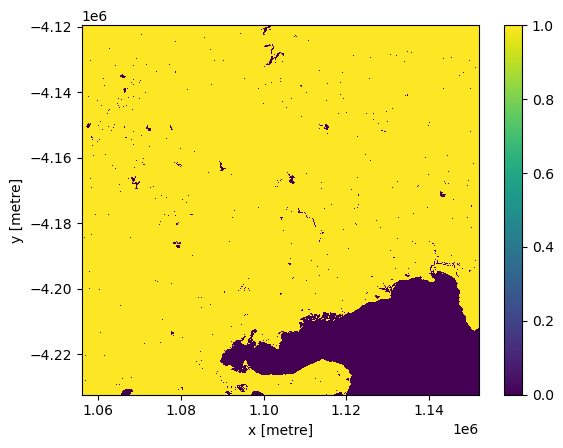

In [80]:
collection_3_wofs_urban_mask.plot()